### Notebook for extracting the iteration-wise learning curves from output json

In [6]:
import json
import matplotlib.pyplot as plt

def extract_iteration_wise_curves(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    extracted_data = []

    for child in data['metadata']['json']['children']:
        if child['tag'] == 'build_curves':
            for anchor in child['children']:
                if anchor['tag'] == 'anchor':
                    # extract the value from anchor
                    anchor_data = {'Anchor': anchor['metadata']['value'], 'Iterations': []}
                    for epoch in anchor['children'][1]['children']:  
                        # extract the value from epoch
                        if epoch['tag'] == 'epoch':
                            iteration_data = { 'epoch': epoch['metadata']['value'], 'metrics': {} }
                            # extract the metric values
                            for phase in epoch['children'][1]['children']:  
                                if phase['tag'] == 'metrics':
                                    for phase_child in phase['children']:
                                        if phase_child['tag'] in ['train', 'val', 'test']:
                                            metrics_data = {'confusion_matrix': None, 'auc': None, 
                                                            'log_loss': None, 'brier_score': None }
                                            for metric in phase_child['children']:
                                                if metric['tag'] == 'confusion_matrix':
                                                    metrics_data['confusion_matrix'] = metric['metadata']['value']
                                                elif metric['tag'] == 'auc':
                                                    metrics_data['auc'] = metric['metadata']['value']
                                                elif metric['tag'] == 'log_loss':
                                                    metrics_data['log_loss'] = metric['metadata']['value']
                                                elif metric['tag'] == 'brier_score':
                                                    metrics_data['brier_score'] = metric['metadata']['value']
                                            iteration_data['metrics'][phase_child['tag']] = metrics_data
                            anchor_data['Iterations'].append(iteration_data)
                    extracted_data.append(anchor_data)
    return extracted_data


### Extract the entire results

In [8]:
# target curve w.r.t. anchor and metric
target_ANCHOR = 23
target_METRIC = 'brier_score'      # 'log_loss' / 'brier_score'
file_path = 'out_3.json'
 

# extract the results from json
results = extract_iteration_wise_curves(file_path)
anchor_results = [item for item in results if item['Anchor'] == target_ANCHOR]
# epoch and metric IN the target anchor
epochs = [item['epoch'] for item in anchor_results[0]['Iterations']]
train_metric_list = [item['metrics']['train'][target_METRIC] for item in anchor_results[0]['Iterations']]
val_metric_list = [item['metrics']['val'][target_METRIC] for item in anchor_results[0]['Iterations']]
test_metric_list = [item['metrics']['test'][target_METRIC] for item in anchor_results[0]['Iterations']]

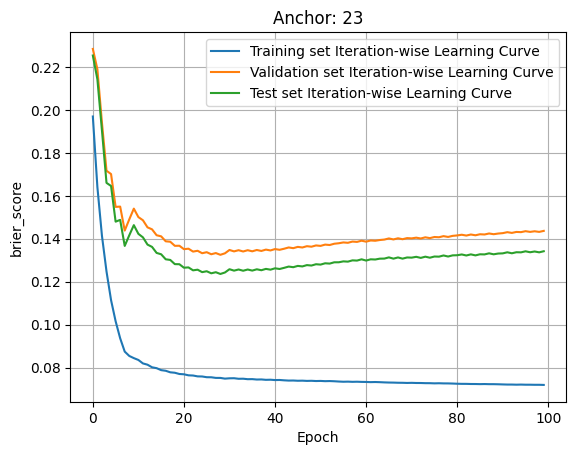

In [9]:
plt.plot(epochs, train_metric_list, label = 'Training set Iteration-wise Learning Curve')
plt.plot(epochs, val_metric_list, label = 'Validation set Iteration-wise Learning Curve')
plt.plot(epochs, test_metric_list, label = 'Test set Iteration-wise Learning Curve')
plt.xlabel('Epoch')
plt.ylabel(target_METRIC)
plt.title(f'Anchor: {target_ANCHOR}')
plt.grid(True)
plt.legend()
plt.show()